假设你有一组文档（如PDF、Notion页面、客户问题等），并希望对其内容进行总结。

大型语言模型（LLMs）在理解和综合文本方面表现出色，因此非常适合用来进行总结。

在检索增强生成（retrieval-augmented generation）的应用场景中，文本总结有助于提炼从大量检索到的文档中获取的信息，为LLM提供背景上下文。

在本文中，我们将介绍如何使用LLMs对多个文档的内容进行总结。

![](../images/summarization_use_case_1-874f7b2c94f64216f1f967fb5aca7bc1.png)

# 概述
在构建总结器时，一个核心问题是如何将文档内容传入LLM的上下文窗口。有两种常见的方法：

Stuff（填充法）：将所有文档直接“填充”到一个单一的提示中。这是最简单的方法（更多关于此方法的信息可以参考create_stuff_documents_chain构造器的说明）。

Map-reduce（映射-归约法）：在“映射”步骤中先分别对每个文档进行总结，然后将这些总结“归约”为一个最终的总结（更多关于此方法的信息可以参考MapReduceDocumentsChain的说明）。

需要注意的是，map-reduce方法尤其在理解子文档内容不依赖于前后文时非常有效。例如，在总结一组较短的文档时。如果是像总结小说或具有内在序列关系的文本，[逐步精炼](https://python.langchain.com/docs/how_to/summarize_refine/)的方法可能会更加有效。

![](../images/summarization_use_case_2-f2a4d5d60980a79140085fb7f8043217.png)

In [3]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model='qwen-plus')

In [5]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

# 填充法：在一次LLM调用中总结
我们可以使用 create_stuff_documents_chain 方法，特别是当使用具有更大上下文窗口的模型时，例如：

128k token 的 OpenAI GPT-4o

200k token 的 Anthropic Claude-3-5-sonnet-20240620

该方法会将文档列表传入，将所有文档插入到一个提示中，然后将这个提示传递给LLM进行处理。

In [7]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)
chain = prompt | llm
result = chain.invoke({"context": docs})

In [8]:
result.pretty_print()

================================== Ai Message ==================================

The article "LLM Powered Autonomous Agents" by Lilian Weng explores the concept of building autonomous agents using large language models (LLMs) as central controllers, exemplified by systems like AutoGPT, GPT-Engineer, and BabyAGI. These agents go beyond text generation, functioning as general problem solvers through integration of three core components: **planning**, **memory**, and **tool use**.

1. **Planning**: Agents break down complex tasks into subgoals using techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT). They improve via self-reflection methods such as ReAct (reasoning + action), Reflexion (learning from failures), and Chain of Hindsight (learning from feedback sequences).

2. **Memory**: 
   - *Short-term memory* relies on in-context learning within the model’s context window.
   - *Long-term memory* uses external vector stores with fast retrieval (e.g., via MIPS algorithms l

# 映射-归约法：通过并行化总结长文本
我们来详细讲解一下映射-归约法。首先，我们会使用LLM将每个文档映射为一个独立的总结。然后，我们将这些总结进行归约或整合，最终得到一个全局总结。

需要注意的是，映射步骤通常会并行化处理输入的文档。

LangGraph，基于 langchain-core 构建，支持映射-归约工作流，非常适合解决这个问题

## 映射步骤
首先，我们需要定义与映射步骤相关的提示。我们可以使用与填充法（Stuff 方法）中相同的总结提示，如下所示：

In [9]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}\\n\\nHelpful Answer:")]
)

## 归约步骤
我们还需要定义一个提示，接收文档映射的结果，并将它们归约为一个单一的输出。

In [10]:
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

## 使用 LangGraph 进行 orchestration（协调）
下面我们实现一个简单的应用程序，首先在文档列表上进行总结映射步骤，然后使用上述提示将它们归约成一个最终输出。

映射-归约流程在文本较长、而LLM的上下文窗口较小时尤其有用。对于较长的文本，我们需要一个机制来确保在归约步骤中，待总结的上下文不会超过模型的上下文窗口大小。

首先，我们将博客文章划分成更小的“子文档”以供映射处理：

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=100
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Generated 16 documents.


接下来，定义图（Graph）。

In [12]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain_core.documents import Document
from langgraph.graph import StateGraph, END, START
from langgraph.types import Send

TOKEN_MAX = 1000


# ------------------------------------------------------------
# STATE DEFINITIONS
# ------------------------------------------------------------

class OverallState(TypedDict):
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


class SummaryState(TypedDict):
    content: str


# ------------------------------------------------------------
# TOKEN UTILITY
# ------------------------------------------------------------

def length_function(docs: List[Document]) -> int:
    return sum(llm.get_num_tokens(doc.page_content) for doc in docs)


# ------------------------------------------------------------
# MAP NODE — per-document summary
# ------------------------------------------------------------

async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


def map_summaries(state: OverallState):
    return [Send("generate_summary", {"content": c}) for c in state["contents"]]


# ------------------------------------------------------------
# COLLECT SUMMARIES
# ------------------------------------------------------------

def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(text) for text in state["summaries"]]
    }


# ------------------------------------------------------------
# REDUCE FUNCTION — summarize a batch of Documents
# ------------------------------------------------------------

async def _reduce(doc_list: List[Document]) -> str:
    prompt = reduce_prompt.invoke(doc_list)
    response = await llm.ainvoke(prompt)
    return response.content


# ------------------------------------------------------------
# CHUNKING (replacement for deprecated split_list_of_docs)
# ------------------------------------------------------------

def chunk_docs(docs: List[Document], max_tokens: int) -> List[List[Document]]:
    batches = []
    current = []
    current_tokens = 0

    for doc in docs:
        tokens = llm.get_num_tokens(doc.page_content)
        if current_tokens + tokens > max_tokens and current:
            batches.append(current)
            current = [doc]
            current_tokens = tokens
        else:
            current.append(doc)
            current_tokens += tokens

    if current:
        batches.append(current)

    return batches


# ------------------------------------------------------------
# COLLAPSE NODE (replacement for deprecated acollapse_docs)
# ------------------------------------------------------------

async def collapse_summaries(state: OverallState):
    docs = state["collapsed_summaries"]

    batches = chunk_docs(docs, TOKEN_MAX)

    reduced_docs = []
    for batch in batches:
        reduced_text = await _reduce(batch)
        reduced_docs.append(Document(reduced_text))

    return {"collapsed_summaries": reduced_docs}


# ------------------------------------------------------------
# DECIDE WHETHER MORE COLLAPSE IS NEEDED
# ------------------------------------------------------------

def should_collapse(
        state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    total_tokens = length_function(state["collapsed_summaries"])
    return (
        "collapse_summaries"
        if total_tokens > TOKEN_MAX
        else "generate_final_summary"
    )


# ------------------------------------------------------------
# FINAL SUMMARY
# ------------------------------------------------------------

async def generate_final_summary(state: OverallState):
    final = await _reduce(state["collapsed_summaries"])
    return {"final_summary": final}


# ------------------------------------------------------------
# GRAPH BUILD
# ------------------------------------------------------------

graph = StateGraph(OverallState)

graph.add_node("generate_summary", generate_summary)
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# edges
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

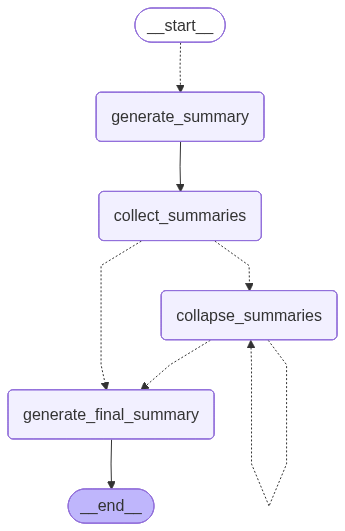

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

在运行应用程序时，我们可以流式输出图的执行过程，以观察它的步骤顺序。下面，我们将简单地打印出每个步骤的名称。

需要注意的是，由于图中有循环，因此在执行时指定 recursion_limit 参数会很有帮助。当超过指定的递归限制时，它会抛出一个特定的错误。

In [15]:
async for step in app.astream(
        {"contents": [doc.page_content for doc in split_docs]},
        {"recursion_limit": 20},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


In [27]:
print(step.get("generate_final_summary").get("final_summary"))

### **Final Consolidated Summary: Main Themes**

The evolution of modern technology is defined by a powerful convergence between **intelligent AI systems** and **robust software engineering**, unified by core principles: **modularity, autonomy, reliability, and responsible design**. Across domains—from game architectures to LLM-powered agents—several key themes emerge as foundational to future innovation:

---

#### 🌐 **Autonomous, Goal-Driven Intelligence**
AI is transitioning from reactive tools to **proactive, self-directed agents** capable of reasoning, planning, and continuous improvement. These agents leverage:
- **Advanced reasoning techniques** (Chain-of-Thought, Tree of Thoughts, PDDL) for complex task decomposition.
- **Dynamic tool use** (via ReAct, HuggingGPT, OpenAI Function Calling) to interact with external systems and APIs.
- **Multi-layered memory** combining short-term context with long-term vector storage, enabling continuity and learning.
- **Self-reflection and ada